### Requirements

In [1]:
import numpy as np
import pandas as pd
import chardet
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data Gathering

In [2]:
rawdata = open('WELLCOME_APCspend2013_forThinkful.csv', "rb").read()
result = chardet.detect(rawdata)
charenc = result['encoding']
charenc

'Windows-1254'

In [3]:
df = pd.read_csv('WELLCOME_APCspend2013_forThinkful.csv', encoding = 'unicode_escape')
df.head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


Once the dataset was read as pandas dataframe, a quick assessment (see below) of the data showed a "complete" dataset with most fields complete, however, a deeper assessment will give a better idea about the quality of the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 5 columns):
PMID/PMCID                                             1928 non-null object
Publisher                                              2127 non-null object
Journal title                                          2126 non-null object
Article title                                          2127 non-null object
COST (£) charged to Wellcome (inc VAT when charged)    2127 non-null object
dtypes: object(5)
memory usage: 83.2+ KB


### Data Assessing and Cleaning

In [5]:
df_clean = df.copy()

As seen below, there are 984 "unique" Journal titles and 299 unique Publisher in the dataset

In [6]:
print(df_clean['Journal title'].nunique())

print(df_clean['Publisher'].nunique())

984
299


Since most of the fields of interest contain strings, the removal of leading and trailing whitespace may help reducing the size of the 'Publisher' and 'Journal title' fields. Similarly, replacing the symbol '&' by 'and' may also achieved a good result

In [7]:
df_clean['Journal title'] = df_clean['Journal title'].str.lower().str.strip()

df_clean['Publisher'] = df_clean['Publisher'].str.lower().str.strip()

df_clean['Journal title'] = df_clean['Journal title'].str.replace('&', 'and', regex = False)

df_clean['Publisher'] = df_clean['Publisher'].str.replace('&', 'and', regex = False)

As it can be seen below, the modifications performed effectively reduced the size of the mentioned fields

In [8]:
print(df_clean['Journal title'].nunique())

print(df_clean['Publisher'].nunique())

881
251


Before starting cleaning the larger fields, visual assessment of the field 'Publisher' suggests the presence of multiple records containing small variations of the same 'Publisher', therefore incresing the size of the corresponding field

In [9]:
df_clean['Publisher'].value_counts()

elsevier                                                   399
public library of science                                  278
wiley                                                      148
oxford university press                                     85
springer                                                    82
biomed central                                              60
wiley-blackwell                                             56
oup                                                         56
nature publishing group                                     49
asbmb                                                       46
bmc                                                         26
bmj                                                         25
nature                                                      25
plos                                                        24
frontiers                                                   23
royal society                                          

In the case of the 'Publisher' field, certain records contained wrong information that was only confirmed by searching information about the particular article on the internet and manually inputing the correct information (see below)

In [10]:
df_clean.at[173, 'Publisher'] = 'portland press'
df_clean.at[174, 'Publisher'] = 'elsevier'
df_clean.at[1622, 'Publisher'] = 'biomed central (bmc)'
df_clean.at[1621, 'Publisher'] = 'elsevier'
df_clean.at[15, 'Publisher'] = 'elsevier'
df_clean.at[376, 'Publisher'] = 'endocrine society'
df_clean.at[373, 'Publisher'] = 'american physiological society'
df_clean.at[[378, 1107], 'Publisher'] = 'international aids society'
df_clean.at[1620, 'Publisher'] = 'endocrine society'
df_clean.at[1682, 'Publisher'] = 'bioscientifica'
df_clean.at[1810, ['PMID/PMCID', 'Journal title']] = 'PMC4214402', 'azania'
df_clean.at[406, 'Publisher'] = 'taylor and francis'

In the case of more general issues (e.g. typos, abbreviations, etc), built-in string methods and regular expressions allowed for programatic cleaning in order to combine records related to the same 'Publisher' under a unique name

In [11]:
df_clean['acs'] = df_clean['Publisher'].str.contains('acs|american chemical society', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['acs'], 'american chemical society (acs)', df_clean['Publisher'])
df_clean.drop('acs', axis = 1, inplace = True)

df_clean['wiley'] = df_clean['Publisher'].str.extract(r'([w][ile]{3}[y])', expand = True)
df_clean['Publisher'] = np.where(df_clean['wiley'] == 'wiley', 'john wiley and sons', df_clean['Publisher'])
df_clean.drop('wiley', axis = 1, inplace = True)

df_clean['wiley'] = df_clean['Publisher'].str.contains('[w][ile]{3}[y]', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['wiley'], 'john wiley and sons', df_clean['Publisher'])
df_clean.drop('wiley', axis = 1, inplace = True)

df_clean['plos'] = df_clean['Publisher'].str.contains('plos|public library of science', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['plos'], 'plos (public library of science)', df_clean['Publisher'])
df_clean.drop('plos', axis = 1, inplace = True)

df_clean['springer'] = df_clean['Publisher'].str.contains('springer', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['springer'], 'springer', df_clean['Publisher'])
df_clean.drop('springer', axis = 1, inplace = True)

df_clean['ox'] = df_clean['Publisher'].str.contains('oxford|^[o][u][p]', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['ox'], 'oxford university press', df_clean['Publisher'])
df_clean.drop('ox', axis = 1, inplace = True)

df_clean['nat'] = df_clean['Publisher'].str.contains('[n][atur]{4}[e]|npg', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['nat'], 'nature publishing group', df_clean['Publisher'])
df_clean.drop('nat', axis = 1, inplace = True)

df_clean['bmc'] = df_clean['Publisher'].str.contains('biomed|^bmc', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['bmc'], 'biomed central (bmc)', df_clean['Publisher'])
df_clean.drop('bmc', axis = 1, inplace = True)

df_clean['elsevier'] = df_clean['Publisher'].str.contains('[e][lsevie]{6}[r]|elseveier|cell press', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['elsevier'], 'elsevier', df_clean['Publisher'])
df_clean.drop('elsevier', axis = 1, inplace = True)

df_clean['bmj'] = df_clean['Publisher'].str.contains('[b][m][j]|british', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['bmj'], 'the british medical journal (bmj)', df_clean['Publisher'])
df_clean.drop('bmj', axis = 1, inplace = True)

df_clean['royalsoc'] = df_clean['Publisher'].str.contains('royal society$', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['royalsoc'], 'the royal society', df_clean['Publisher'])
df_clean.drop('royalsoc', axis = 1, inplace = True)

df_clean['royalchem'] = df_clean['Publisher'].str.contains('royal society \w+ chemistry|[r][s][c]', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['royalchem'], 'the royal society of chemistry', df_clean['Publisher'])
df_clean.drop('royalchem', axis = 1, inplace = True)

df_clean['frontiers'] = df_clean['Publisher'].str.contains('[f][rontier]{7}[s]?', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['frontiers'], 'frontiers media', df_clean['Publisher'])
df_clean.drop('frontiers', axis = 1, inplace = True)

df_clean['asbmb'] = df_clean['Publisher'].str.contains('american society for biochemistry|[a][sbm]{3}[b]?|cadmus|american soc for biochemistry', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['asbmb'], 'american society for biochemistry and molecular biology (asbmb)', df_clean['Publisher'])
df_clean.drop('asbmb', axis = 1, inplace = True)

df_clean['camb'] = df_clean['Publisher'].str.contains('[c][amb]{3}\w+|[c][u][p]', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['camb'], 'cambridge university press', df_clean['Publisher'])
df_clean.drop('camb', axis = 1, inplace = True)

df_clean['tf'] = df_clean['Publisher'].str.contains('[t][ay]{2}\w+|[f][ranci]{5}[s]?|tandf', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['tf'], 'taylor and francis', df_clean['Publisher'])
df_clean.drop('tf', axis = 1, inplace = True)

df_clean['dt'] = df_clean['Publisher'].str.contains('[d][ar]{2}\w+', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['dt'], 'darmouth journal services', df_clean['Publisher'])
df_clean.drop('dt', axis = 1, inplace = True)

df_clean['comp'] = df_clean['Publisher'].str.contains('[c][ompan]{5}\w+', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['comp'], 'the company of biologists', df_clean['Publisher'])
df_clean.drop('comp', axis = 1, inplace = True)

df_clean['asm'] = df_clean['Publisher'].str.contains('[a][s][m]|^american.*microbiology$', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['asm'], 'american society for microbiology (asm)', df_clean['Publisher'])
df_clean.drop('asm', axis = 1, inplace = True)

df_clean['pnas'] = df_clean['Publisher'].str.contains('^[n][ati]{3}\w+|[a][c][a]\w+|[p][nas]{3}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['pnas'], 'national academy of sciences of the united states of america', df_clean['Publisher'])
df_clean.drop('pnas', axis = 1, inplace = True)

df_clean['landes'] = df_clean['Publisher'].str.contains('[l][andes]{5}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['landes'], 'landes bioscience', df_clean['Publisher'])
df_clean.drop('landes', axis = 1, inplace = True)

df_clean['soc'] = df_clean['Publisher'].str.contains('^[s][ociety]{6}.*[m][icro]{4}\w+', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['soc'], 'society for general microbiology', df_clean['Publisher'])
df_clean.drop('soc', axis = 1, inplace = True)

df_clean['sage'] = df_clean['Publisher'].str.contains('[s][age]{3}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['sage'], 'sage publishing', df_clean['Publisher'])
df_clean.drop('sage', axis = 1, inplace = True)

df_clean['port'] = df_clean['Publisher'].str.contains('[p][ort]{3}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['port'], 'portland press', df_clean['Publisher'])
df_clean.drop('port', axis = 1, inplace = True)

df_clean['neuro'] = df_clean['Publisher'].str.contains('[n][e][uro]{3}|[sfn]{3}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['neuro'], 'society for neuroscience', df_clean['Publisher'])
df_clean.drop('neuro', axis = 1, inplace = True)

df_clean['cryst'] = df_clean['Publisher'].str.contains('[i][ucr]{3}|[c][rys]{3}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['cryst'], 'international union of crystallography (iucr)', df_clean['Publisher'])
df_clean.drop('cryst', axis = 1, inplace = True)

df_clean['endo'] = df_clean['Publisher'].str.contains('[e][nd]{2}.*[e]', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['endo'], 'endocrine society', df_clean['Publisher'])
df_clean.drop('endo', axis = 1, inplace = True)

df_clean['wolt'] = df_clean['Publisher'].str.contains('[w][ol]{2}.*|[k][lu]{2}.*', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['wolt'], 'wolters kluwer', df_clean['Publisher'])
df_clean.drop('wolt', axis = 1, inplace = True)

df_clean['physio'] = df_clean['Publisher'].str.contains('[p][hy]{2}[sio]{3}.*|[a][p][s]', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['physio'], 'american physiological society', df_clean['Publisher'])
df_clean.drop('physio', axis = 1, inplace = True)

df_clean['faseb'] = df_clean['Publisher'].str.contains('[f][ed]{2}.*|[f][ase]{3}[b]', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['faseb'], 'federation of american societies for experimental biology (faseb)', df_clean['Publisher'])
df_clean.drop('faseb', axis = 1, inplace = True)

df_clean['ash'] = df_clean['Publisher'].str.contains('[h][ema]{3}.*|[a][s][h]', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['ash'], 'american society of hematology (ash)', df_clean['Publisher'])
df_clean.drop('ash', axis = 1, inplace = True)

df_clean['sher'] = df_clean['Publisher'].str.contains('sheridan', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['sher'], 'the sheridan press', df_clean['Publisher'])
df_clean.drop('sher', axis = 1, inplace = True)

df_clean['roy'] = df_clean['Publisher'].str.contains('royal college', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['roy'], 'royal college of psychiatrists', df_clean['Publisher'])
df_clean.drop('roy', axis = 1, inplace = True)

df_clean['fut'] = df_clean['Publisher'].str.contains('future|medicine', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['fut'], 'future medicine', df_clean['Publisher'])
df_clean.drop('fut', axis = 1, inplace = True)

df_clean['cold'] = df_clean['Publisher'].str.contains('cold|cshlp', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['cold'], 'cold spring harbor laboratory press', df_clean['Publisher'])
df_clean.drop('cold', axis = 1, inplace = True)

df_clean['mary'] = df_clean['Publisher'].str.contains('[m][ary]{3}|[l][ieber]{5}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['mary'], 'mary ann liebert', df_clean['Publisher'])
df_clean.drop('mary', axis = 1, inplace = True)

df_clean['hind'] = df_clean['Publisher'].str.contains('[h][ind]{3}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['hind'], 'hindawi', df_clean['Publisher'])
df_clean.drop('hind', axis = 1, inplace = True)

df_clean['jove'] = df_clean['Publisher'].str.contains('[m][y].*?[j]|visualized|jove', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['jove'], 'myjove corporation', df_clean['Publisher'])
df_clean.drop('jove', axis = 1, inplace = True)

df_clean['biophys'] = df_clean['Publisher'].str.contains('[b][iophy]{5}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['biophys'], 'biophysical society', df_clean['Publisher'])
df_clean.drop('biophys', axis = 1, inplace = True)

df_clean['bent'] = df_clean['Publisher'].str.contains('[b][ent]{3}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['bent'], 'bentham science publishers', df_clean['Publisher'])
df_clean.drop('bent', axis = 1, inplace = True)

df_clean['imp'] = df_clean['Publisher'].str.contains('[i][mpa]{3}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['imp'], 'impact journals', df_clean['Publisher'])
df_clean.drop('imp', axis = 1, inplace = True)

df_clean['leu'] = df_clean['Publisher'].str.contains('[l][eu]{2}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['leu'], 'society for leukocyte biology', df_clean['Publisher'])
df_clean.drop('leu', axis = 1, inplace = True)

df_clean['mit'] = df_clean['Publisher'].str.contains('[m][it]{2}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['mit'], 'mit press', df_clean['Publisher'])
df_clean.drop('mit', axis = 1, inplace = True)

df_clean['info'] = df_clean['Publisher'].str.contains('[i][nfo]{3}', case = False, regex = True)
df_clean['Publisher'] = np.where(df_clean['info'], 'informa healthcare communications', df_clean['Publisher'])
df_clean.drop('info', axis = 1, inplace = True)

As it can be noted below, through manual and programmatic cleaning, the size of the 'Publisher' field was effectively reduced from 299 unique names to 85

In [12]:
df_clean['Publisher'].nunique()

85

In [13]:
df_clean['Publisher'].value_counts()

elsevier                                                             414
plos (public library of science)                                     307
john wiley and sons                                                  270
oxford university press                                              167
biomed central (bmc)                                                  96
springer                                                              95
american society for biochemistry and molecular biology (asbmb)       84
nature publishing group                                               81
the british medical journal (bmj)                                     58
national academy of sciences of the united states of america          36
american chemical society (acs)                                       34
cambridge university press                                            33
frontiers media                                                       32
the royal society                                  

Next, a similar approach was taken to assess and clean the 'Journal title' field, however, only the top most common 'Journal title' were assessed and cleaned due to the considerably larger size of the field compared to the 'Publisher' field

In [14]:
df_clean['Journal title'].nunique()

881

It was found that only one record was missing the information conrresponding to the 'Journal title'. Manual inputation was not possible since information needed to retrieve additional information was not available. The record was removed from the dataset

In [15]:
df_clean[df_clean['Journal title'].isnull()]

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
986,NaN,macmillan,NaN,Fungal Disease in Britain and the United State...,£13200.00


In [16]:
df_clean.dropna(subset = ['Journal title'], inplace = True)

Similarly to the cleaning of the 'Publisher' field, manual correction of wrong information was performed using manual inputation after confirming the right information using the internet

In [17]:
df_clean.at[1345, ['Publisher', 'Journal title']] = 'sage publishing', 'Health: An Interdisciplinary Journal for the Social Study of Health, Illness and Medicine'
df_clean.at[1256, 'Journal title'] = 'age and ageing'
df_clean.at[1255, 'Journal title'] = 'health policy and planning'
df_clean.at[429, 'Journal title'] = 'genetics'
df_clean.at[[430, 431, 436], 'Publisher'] = 'national academy of sciences of the united states of america'
df_clean.at[767, 'Journal title'] = 'public health1'
df_clean.at[339, 'Publisher'] = 'society for neuroscience'
df_clean.at[397, 'Journal title'] = 'biology open'
df_clean.at[547, 'Journal title'] = 'behaviour research and therapy'
df_clean.at[548, 'Journal title'] = 'the journal of pediatrics'
df_clean.at[549, ['Publisher', 'Journal title']] = 'john wiley and sons', 'pathogens and disease'
df_clean.at[550, 'Journal title'] = 'health and place'
df_clean.at[551, 'Journal title'] = 'drug and alcohol dependence'
df_clean.at[552, 'Journal title'] = 'lancet'
df_clean.at[546, 'Journal title'] = 'brain, behavior, and immunity'
df_clean.at[1205, ['PMID/PMCID', 'Journal title']] = 'PMC3530408', 'british medical bulletin'

A more general programmatic approach allowed for cleaning of the data for the 20 most common journal titles in the set


In [18]:
df_clean['plos1'] = df_clean['Journal title'].str.contains('[p][l][o][s].*?[o][ne]{2}|[p][l][o][s].*?1|plos$|pone-d12-17947|public library of science', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['plos1'], 'plos one', df_clean['Journal title'])
df_clean.drop('plos1', axis = 1, inplace = True)

df_clean['jbc'] = df_clean['Journal title'].str.contains('journal of biological chemistry|j biol chem.|j biol chemistry|jnl biological chemistry|journal of biol chem|journal biological chemistry|the journal of biological chemistry|biological chemistry|biologicial chemistry', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['jbc'], 'journal of biological chemistry', df_clean['Journal title'])
df_clean.drop('jbc', axis = 1, inplace = True)

df_clean['nuc'] = df_clean['Journal title'].str.contains('nucleic acid[s]? research', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['nuc'], 'nucleic acids research', df_clean['Journal title'])
df_clean.drop('nuc', axis = 1, inplace = True)

df_clean['pntd'] = df_clean['Journal title'].str.contains('neglected tropical disease|pntd|plos negected tropical diseases|plos ntd', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['pntd'], 'plos neglected tropical diseases', df_clean['Journal title'])
df_clean.drop('pntd', axis = 1, inplace = True)

df_clean['pnas'] = df_clean['Journal title'].str.contains('national academy of sciences|pnas|proc natl acad sci u s a.', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['pnas'], 'proceedings of the national academy of sciences', df_clean['Journal title'])
df_clean.drop('pnas', axis = 1, inplace = True)

df_clean['hmg'] = df_clean['Journal title'].str.contains('[h][uman]{4}.*[m][ol]{2}.*?[g][ene]{3}', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['hmg'], 'human molecular genetics', df_clean['Journal title'])
df_clean.drop('hmg', axis = 1, inplace = True)

df_clean['brain'] = df_clean['Journal title'].str.contains('^[b][rain]{4}$|brain online', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['brain'], 'brain', df_clean['Journal title'])
df_clean.drop('brain', axis = 1, inplace = True)

df_clean['pubh'] = df_clean['Journal title'].str.contains('^public health$|bmc public|[b][m][c].*[p][u]', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['pubh'], 'bmc public health', df_clean['Journal title'])
df_clean.drop('pubh', axis = 1, inplace = True)

df_clean['neuro'] = df_clean['Journal title'].str.contains('^journal of neuroscience$|the journal of neuroscience', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['neuro'], 'journal of neuroscience', df_clean['Journal title'])
df_clean.drop('neuro', axis = 1, inplace = True)

df_clean['biochem'] = df_clean['Journal title'].str.contains('[b][iochem]{6}.*[j].*?', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['biochem'], 'biochemical journal', df_clean['Journal title'])
df_clean.drop('biochem', axis = 1, inplace = True)

df_clean['develop'] = df_clean['Journal title'].str.contains('[d][ev]{2}.*[c][ell]{3}?', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['develop'], 'developmental cell', df_clean['Journal title'])
df_clean.drop('develop', axis = 1, inplace = True)

df_clean['bio'] = df_clean['Journal title'].str.contains('[c][urr]{3}.*[^o][b][io]{2}', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['bio'], 'current biology', df_clean['Journal title'])
df_clean.drop('bio', axis = 1, inplace = True)

df_clean['bmj'] = df_clean['Journal title'].str.contains('british medical journal|bmj$', case = False, regex = True)
df_clean['Journal title'] = np.where(df_clean['bmj'], 'bmj', df_clean['Journal title'])
df_clean.drop('bmj', axis = 1, inplace = True)

Upon cleaning, the five most common journal titles in the dataset were following:

In [19]:
df_clean['Journal title'].value_counts()[:5]

plos one                                           213
journal of biological chemistry                     73
proceedings of the national academy of sciences     39
nucleic acids research                              29
neuroimage                                          29
Name: Journal title, dtype: int64

The last cleaning effort before performing analyses, was to clean the 'PMID/PMCID' field. This field contain unique identification information for each article in the dataset, however, the original visual assessment of the data reveal multiple variations in formatting. In order to solve these issues, built-in string methods combined with regular expressions, permitted the extraction and creation of two new fields containing the information corresponding to each identifier, the european (PM_ID) and the american (PMC_ID)

In [20]:
df_clean['PMID/PMCID'] = df_clean['PMID/PMCID'].str.replace('\n', '', regex = False)
df_clean['PMC'] = df_clean['PMID/PMCID'].str.extract(r'[P]?[M]?[C]?[I]?[D]?:?([P][M][C][I]?[D]?\s*?[3][0-9]{6})', expand = True)
df_clean['PMC'] = df_clean['PMC'].str.replace('PMC', '', regex = False)
df_clean['PM_ID'] = df_clean['PMID/PMCID'].str.extract(r'[P]?[M]?[I]?[D]?:?([2][0-9]{7})', expand = True)
df_clean['PMC2'] = df_clean['PMID/PMCID'].str.extract(r'^([3][0-9]{6})', expand = True)
df_clean['PMC_ID'] = df_clean['PMC'].fillna('') + df_clean['PMC2'].fillna('')
df_clean.drop(['PMC', 'PMC2'], axis = 1, inplace = True)
df_clean = df_clean[['PMID/PMCID', 'PMC_ID', 'PM_ID', 'Publisher', 'Journal title', 'Article title', 'COST (£) charged to Wellcome (inc VAT when charged)']]

In [21]:
df_clean.sample(5)

,PMID/PMCID,PMC_ID,PM_ID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
1749,23385540 PMC3669511,3669511,23385540,springer,european child and adolescent psychiatty,Are parental ADHD problems associated with a m...,£2285.92
160,23698002 PMC3696650,3696650,23698002,american society for biochemistry and molecula...,journal of biological chemistry,T-Cell Receptor specifically maintained by alt...,£1566.89
1548,3574120,3574120,NaN,plos (public library of science),plos one,Use of a Molecular Decoy to Segregate Transpor...,£889.97
1630,PMC3730629,3730629,NaN,the royal society,biology letters,Anthelmintic treatment alters the parasite com...,£1680.00
170,23885220 PMC3706957,3706957,23885220,bentham science publishers,current analytical chemistry,Ion mobility spectrometry-mass spectrometry of...,£2142.99


Since our analyses focuses on the 'COST (£) charged to Wellcome (inc VAT when charged)' field, the removal of alphanumeric symbols (£ and $) and the subsequent change in data format to the more appropriate 'float' was performed

In [22]:
df_clean['COST (£) charged to Wellcome (inc VAT when charged)'] = df_clean['COST (£) charged to Wellcome (inc VAT when charged)'].str.replace('£', '', regex = False)
df_clean['COST (£) charged to Wellcome (inc VAT when charged)'] = df_clean['COST (£) charged to Wellcome (inc VAT when charged)'].str.replace('$', '', regex = False)
df_clean['COST (£) charged to Wellcome (inc VAT when charged)'] = df_clean['COST (£) charged to Wellcome (inc VAT when charged)'].astype(float)

In order to simplify the analysis, a subset of the original dataset was assembled containing information for the five most common journals exclusively

In [23]:
top_five_flag = (df_clean['Journal title'] == 'plos one') | (df_clean['Journal title'] == 'journal of biological chemistry') | (df_clean['Journal title'] == 'proceedings of the national academy of sciences') | (df_clean['Journal title'] == 'nucleic acids research') | (df_clean['Journal title'] == 'neuroimage')
df_top_5 = df_clean.loc[top_five_flag, :]
df_top_5.head()

,PMID/PMCID,PMC_ID,PM_ID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
16,22610094,,22610094,american society for biochemistry and molecula...,journal of biological chemistry,Annexin-1 interaction with FPR2/ALX,265.67
60,PMC3576085,3576085,NaN,american society for biochemistry and molecula...,journal of biological chemistry,Understanding how noncatalytic carbohydrate bi...,1100.00
61,23239883 PMC3561570,3561570,23239883,american society for biochemistry and molecula...,journal of biological chemistry,Molecular architecture and functional analysis...,2259.64
62,PMC3481300,3481300,NaN,american society for biochemistry and molecula...,journal of biological chemistry,Structure of the BMP receptor ALK2 and implica...,1487.46
63,PMC3234852,3234852,NaN,american society for biochemistry and molecula...,journal of biological chemistry,Inhibitory member of the apoptosis-stimulating...,1531.08


As it can be seen below, the resulting dataset ('df_top_5') is very complete, however, a visual assessment will provide more information about its quality

In [24]:
df_top_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 16 to 1835
Data columns (total 7 columns):
PMID/PMCID                                             370 non-null object
PMC_ID                                                 383 non-null object
PM_ID                                                  59 non-null object
Publisher                                              383 non-null object
Journal title                                          383 non-null object
Article title                                          383 non-null object
COST (£) charged to Wellcome (inc VAT when charged)    383 non-null float64
dtypes: float64(1), object(6)
memory usage: 23.9+ KB


In the plot below, it is very notorius that most of the journals in our dataset have costs associated with them that are way too high in comparison to most of the records

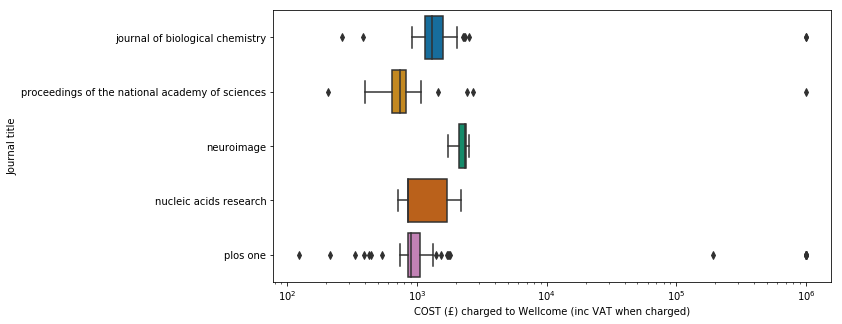

In [25]:
plt.figure(figsize = [10, 5])

sns.boxplot(data = df_top_5, x = 'COST (£) charged to Wellcome (inc VAT when charged)', y = 'Journal title', palette = 'colorblind')
plt.xscale('log');

Filtering the new dataset for records with 'COST (£) charged to Wellcome (inc VAT when charged)' above £ 10,000, revealed that multiple entries were associated with costs of £ 999,999, likely caused by a problem inputing the data or a system related problem. In the case of record indexed as #1470, a value of £ 192,645 seem equally wrong. After considering several approaches for resolving these issues, these wrong values were replaced with 'null values (NaN)' in order to be able to calculate summary statistics for the field based on the 'Journal title' in a more reliable way 

In [26]:
df_top_5[df_top_5['COST (£) charged to Wellcome (inc VAT when charged)'] > 10000]

,PMID/PMCID,PMC_ID,PM_ID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
149,PMC3234811,3234811,NaN,american society for biochemistry and molecula...,journal of biological chemistry,Picomolar nitric oxide signals from central ne...,999999.0
1309,2294692,,NaN,national academy of sciences of the united sta...,proceedings of the national academy of sciences,Shaping accoustic fields as a toolset for micr...,999999.0
1470,3547931,3547931,NaN,plos (public library of science),plos one,Reducing stock-outs of life saving Malaria Com...,192645.0
1560,3726600,3726600,NaN,plos (public library of science),plos one,Plasmodium falciparum vary Gene Expression Hom...,999999.0
1561,23285297,,23285297,plos (public library of science),plos one,Pharmacological inhibition of caspase-2 protec...,999999.0
1562,PMC3720940,3720940,NaN,plos (public library of science),plos one,Population-based CD4 counts in a rural area in...,999999.0
1563,PMCID: PMC3748079,3748079,NaN,plos (public library of science),plos one,Plant SILAC: stable-isotope labelling with ami...,999999.0
1564,PMCID: PMC3579793,3579793,NaN,plos (public library of science),plos one,Phagocytosis Is the Main CR3-Mediated Function...,999999.0
1565,PMCID: PMC3732248,3732248,NaN,plos (public library of science),plos one,Pneumocystis jirovecii pneumonia in tropical a...,999999.0
1566,PMCID: PMC3767740,3767740,NaN,plos (public library of science),plos one,Phenotypic alteration of neutrophils in the bl...,999999.0


In [27]:
df_top_5['COST (£) charged to Wellcome (inc VAT when charged)'] = np.where(df_top_5['COST (£) charged to Wellcome (inc VAT when charged)'] > 10000, np.nan, df_top_5['COST (£) charged to Wellcome (inc VAT when charged)'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


As it can be noted below, the removal of the extreme values from the 'COST (£) charged to Wellcome (inc VAT when charged)' resulted in the appearance of 13 missing records in the dataset. Cleaning approaches that considered inputing the missing values with the mean or median for each 'Journal title' were considered, however, built-in functions that estimate the mentioned statistics without using missing values were used

In [28]:
df_top_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383 entries, 16 to 1835
Data columns (total 7 columns):
PMID/PMCID                                             370 non-null object
PMC_ID                                                 383 non-null object
PM_ID                                                  59 non-null object
Publisher                                              383 non-null object
Journal title                                          383 non-null object
Article title                                          383 non-null object
COST (£) charged to Wellcome (inc VAT when charged)    370 non-null float64
dtypes: float64(1), object(6)
memory usage: 33.9+ KB


In [29]:
means = df_top_5.groupby('Journal title')['COST (£) charged to Wellcome (inc VAT when charged)'].mean()
medians = df_top_5.groupby('Journal title')['COST (£) charged to Wellcome (inc VAT when charged)'].median()
stds = df_top_5.groupby('Journal title')['COST (£) charged to Wellcome (inc VAT when charged)'].std()

df_summary = pd.DataFrame({'Journal Title': means.index, 'Mean (£)': means.values, 'Median (£)': medians.values, 'Standard deviation': stds.values})
df_summary

,Journal Title,Mean (£),Median (£),Standard deviation
0,journal of biological chemistry,1378.140423,1311.730,388.553911
1,neuroimage,2215.168276,2326.430,266.653947
2,nucleic acids research,1162.344828,852.000,442.150934
3,plos one,937.642906,897.610,193.298329
4,proceedings of the national academy of sciences,829.325000,733.125,456.567758


As it can be seen in the table above and the image below, articles published in the journal **Neuroimage** recorded the highest associated costs, with an average cost of £ 2,215.17 per article. Articles in the other four most common journals presented average costs below £ 1378,14 per article. In terms of the median costs, all journal except **Neuroimage** reported values lower than the average costs

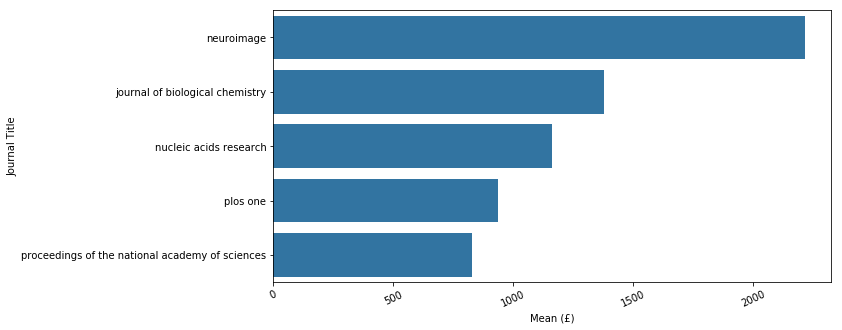

In [30]:
plt.figure(figsize = [10, 5])

order = ['neuroimage', 'journal of biological chemistry', 'nucleic acids research', 'plos one', 'proceedings of the national academy of sciences']
base_color = sns.color_palette()[0]
sns.barplot(data = df_summary, y = 'Journal Title', x = 'Mean (£)', color = base_color, order = order)
plt.xticks(rotation = 25);